# 1. Import Required Libraries
Import all necessary libraries for data processing, visualization, and modeling.

In [ ]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection         import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model            import LogisticRegression
from sklearn.svm                     import LinearSVC
from sklearn.ensemble                import RandomForestClassifier
from sklearn.svm                     import SVC
from sklearn.metrics                 import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)
import nltk
from nltk.corpus                     import stopwords
from nltk.stem                       import WordNetLemmatizer

# 2. Download NLTK Resources
Download stopwords and lemmatizer resources from NLTK.

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words   = set(stopwords.words('english'))
lemmatizer   = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3. Load Dataset
Read the Amazon reviews dataset and display its shape and first few rows.

In [4]:
DATA_PATH = '/kaggle/input/amazon-reviews/train.csv'
df = pd.read_csv(DATA_PATH)
print(f"Rows × Cols: {df.shape}")
df.head()

Rows × Cols: (3600000, 2)


,Review,Label
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


# 4. Sample and Shuffle Data
Sample equal numbers of positive and negative reviews, shuffle, and save to CSV.

In [5]:
sampled_1 = df[df['Label'] == 1].sample(n=20000, random_state=42)

sampled_2 = df[df['Label'] == 2].sample(n=20000, random_state=42)

sampled_df = pd.concat([sampled_1, sampled_2])

df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

df.to_csv('Train.csv', index=False)

# 5. Exploratory Data Analysis
Check for missing values, visualize sentiment distribution, and review length.

Review    0
Label     0
dtype: int64


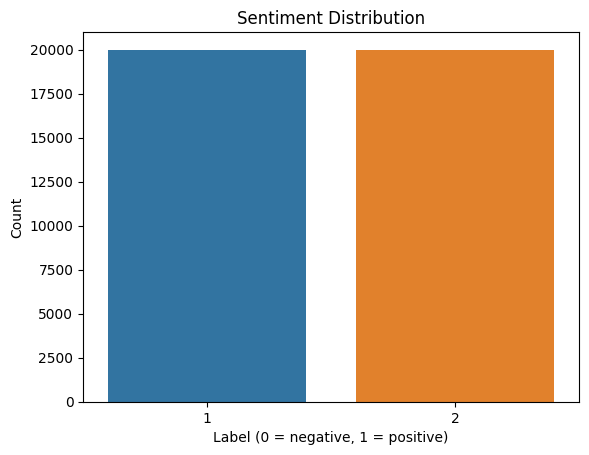

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


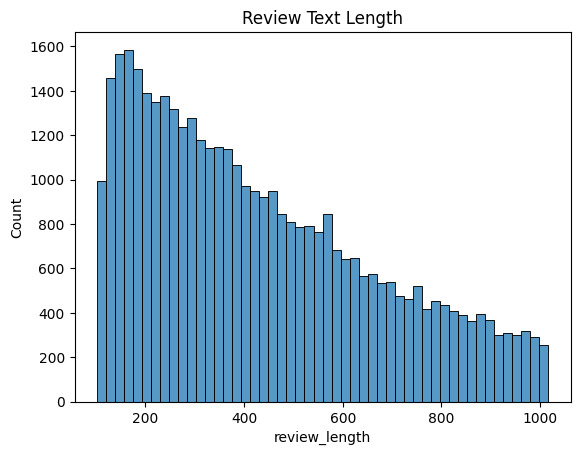

In [6]:
# 4.1 Missing values
print(df.isnull().sum())

# 4.2 Rating distribution
sns.countplot(x='Label', data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Label (0 = negative, 1 = positive)")
plt.ylabel("Count")
plt.show()

# 4.3 Review length distribution
df['review_length'] = df['Review'].str.len()
sns.histplot(df['review_length'], bins=50)
plt.title("Review Text Length")
plt.show()


# 6. Text Preprocessing
Clean and preprocess the review text using regex, stopwords, and lemmatization.

In [7]:
def preprocess(text):
    text = re.sub(r'<.*?>', '', str(text)).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [lemmatizer.lemmatize(w) 
              for w in text.split() 
              if w not in stop_words]
    return ' '.join(tokens)

# 5.1 Clean text
df['clean_text'] = df['Review'].apply(preprocess)


print(df['Label'].value_counts())


Label
2    20000
1    20000
Name: count, dtype: int64


# 7. Train-Test Split
Split the cleaned data into training and testing sets.

In [8]:
X = df['clean_text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 8. TF-IDF Vectorization
Convert the cleaned text data into TF-IDF features.

In [9]:
tfidf = TfidfVectorizer(
    max_features=20_000,
    ngram_range=(1,2)
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# 9. Train and Evaluate Baseline Models
Train Logistic Regression, Random Forest, and SVM models and plot ROC curves.

Training Logistic Regression…
 → done in 0.68s
Training Random Forest…
 → done in 48.20s
Training SVM…


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 → done in 760.87s


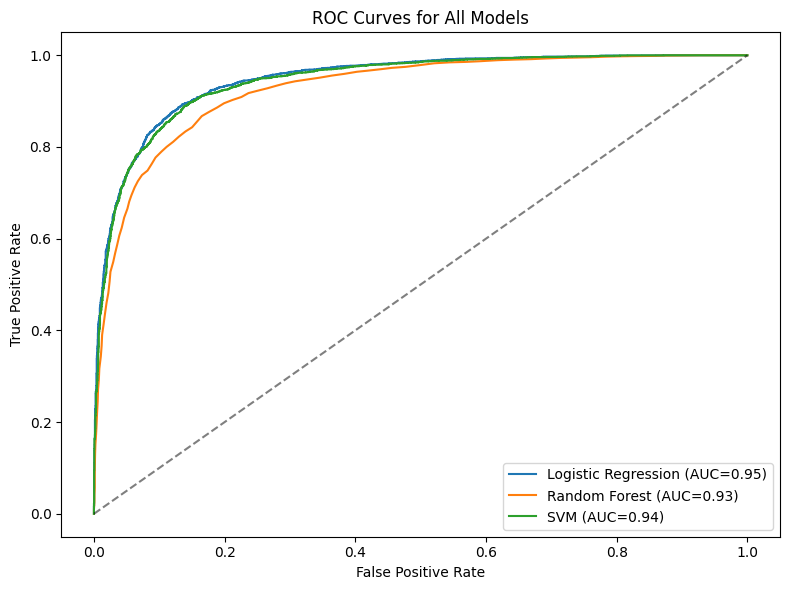

                     train_time  accuracy precision   recall  f1_score  \
Logistic Regression    0.684614  0.877625  0.882308   0.8715  0.876871   
Random Forest         48.202917  0.846375  0.844053  0.84975  0.846892   
SVM                  760.868813  0.872375  0.873028   0.8715  0.872263   

                               confusion_matrix  
Logistic Regression  [[3486, 514], [465, 3535]]  
Random Forest        [[3399, 601], [628, 3372]]  
SVM                  [[3486, 514], [507, 3493]]  


In [10]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest'      : RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM'                : SVC(kernel='linear', probability=True, max_iter=5000)
}

# 1) Set up one figure & axis
fig, ax = plt.subplots(figsize=(8, 6))

results = {}
for name, model in models.items():
    print(f"Training {name}…")
    t0 = time.time()
    model.fit(X_train_tfidf, y_train)
    train_time = time.time() - t0
    print(f" → done in {train_time:.2f}s")

    # get predictions & scores
    y_pred = model.predict(X_test_tfidf)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_tfidf)[:, 1]
    else:
        y_score = model.decision_function(X_test_tfidf)

    # compute ROC
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=2)
    auc = roc_auc_score(y_test, y_score)

    # 2) plot on the *same* axis
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

    # store metrics
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {
        'train_time': train_time,
        'accuracy'  : accuracy_score(y_test, y_pred),
        'precision' : precision_score(y_test, y_pred),
        'recall'    : recall_score(y_test, y_pred),
        'f1_score'  : f1_score(y_test, y_pred),
        'confusion_matrix': cm
    }

# 3) decorate & show
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)      # random-guess line
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for All Models')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Finally, display your results table
df_results = pd.DataFrame(results).T
print(df_results)

# 10. Hyperparameter Tuning
Tune hyperparameters for each model using GridSearchCV and re-evaluate.

Training LR (tuned)…
 → done in 1.92s
Training RF (tuned)…
 → done in 97.18s
Training SVM (tuned)…
 → done in 0.12s


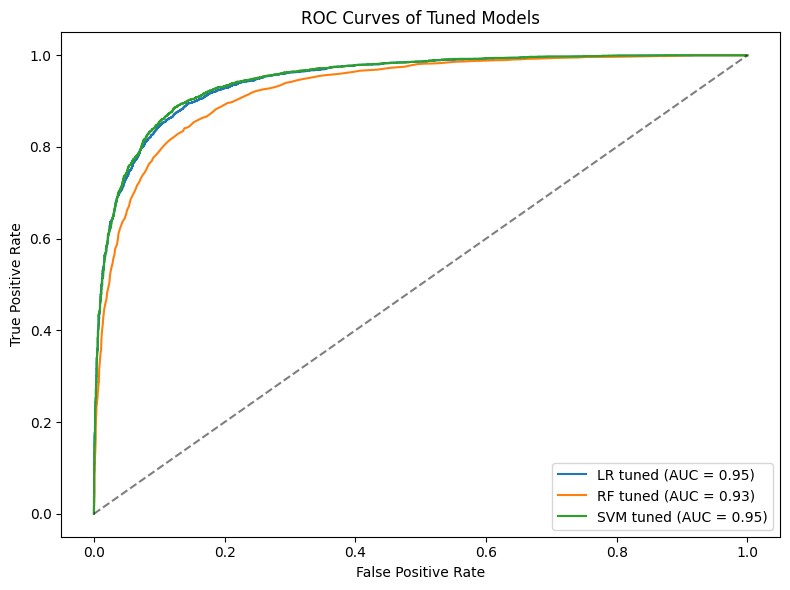

                     train_time  accuracy precision   recall  f1_score  \
Logistic Regression    0.684614  0.877625  0.882308   0.8715  0.876871   
Random Forest         48.202917  0.846375  0.844053  0.84975  0.846892   
SVM                  760.868813  0.872375  0.873028   0.8715  0.872263   
LR tuned               1.918139     0.874  0.878734  0.86775  0.873208   
RF tuned              97.175828  0.849375  0.845147   0.8555  0.850292   
SVM tuned              0.119148  0.881125  0.884489  0.87675  0.880603   

                               confusion_matrix  
Logistic Regression  [[3486, 514], [465, 3535]]  
Random Forest        [[3399, 601], [628, 3372]]  
SVM                  [[3486, 514], [507, 3493]]  
LR tuned             [[3471, 529], [479, 3521]]  
RF tuned             [[3422, 578], [627, 3373]]  
SVM tuned            [[3507, 493], [458, 3542]]  


In [11]:
# 9.1 Logistic Regression tuning
param_lr = {'C': [0.01, 0.1, 1, 10]}
gs_lr = GridSearchCV(LogisticRegression(max_iter=1000),
                     param_lr, cv=3, scoring='f1', n_jobs=-1)
gs_lr.fit(X_train_tfidf, y_train)
best_lr = gs_lr.best_estimator_

# 9.2 Random Forest tuning
param_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
gs_rf = GridSearchCV(RandomForestClassifier(),
                     param_rf, cv=3, scoring='f1', n_jobs=-1)
gs_rf.fit(X_train_tfidf, y_train)
best_rf = gs_rf.best_estimator_

# 9.3 SVM tuning
param_svm = {'C': [0.01, 0.1, 1, 10]}
gs_svm = GridSearchCV(LinearSVC(max_iter=5000),
                      param_svm, cv=3, scoring='f1', n_jobs=-1)
gs_svm.fit(X_train_tfidf, y_train)
best_svm = gs_svm.best_estimator_

# Prepare dictionary of tuned models
tuned = {'LR': best_lr, 'RF': best_rf, 'SVM': best_svm}

# --- NEW: Create one figure & axis for all ROC curves ---
fig, ax = plt.subplots(figsize=(8, 6))

# Re-evaluate tuned models
for name, model in tuned.items():
    print(f"Training {name} (tuned)…")
    t0 = time.time()
    model.fit(X_train_tfidf, y_train)
    train_time = time.time() - t0
    print(f" → done in {train_time:.2f}s")

    # predict & score
    y_pred = model.predict(X_test_tfidf)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_tfidf)[:, 1]
    else:
        y_score = model.decision_function(X_test_tfidf)

    # ROC + AUC
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=2)
    auc = roc_auc_score(y_test, y_score)
    ax.plot(fpr, tpr, label=f"{name} tuned (AUC = {auc:.2f})")

    # store back into the same dict, with “ tuned” suffix
    cm = confusion_matrix(y_test, y_pred)
    results[f"{name} tuned"] = {
        'train_time'       : train_time,
        'accuracy'         : accuracy_score(y_test, y_pred),
        'precision'        : precision_score(y_test, y_pred),
        'recall'           : recall_score(y_test, y_pred),
        'f1_score'         : f1_score(y_test, y_pred),
        'confusion_matrix' : cm
    }

# Decorate & display ROC plot
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves of Tuned Models')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Now your `results` dict contains both original and tuned entries:
df_all = pd.DataFrame(results).T
print(df_all)

# 11. Model Performance Comparison
Sort models by F1-score and visualize the comparison with a bar chart.

,train_time,accuracy,precision,recall,f1_score,confusion_matrix
SVM tuned,0.119148,0.881125,0.884489,0.87675,0.880603,"[[3507, 493], [458, 3542]]"
Logistic Regression,0.684614,0.877625,0.882308,0.8715,0.876871,"[[3486, 514], [465, 3535]]"
LR tuned,1.918139,0.874,0.878734,0.86775,0.873208,"[[3471, 529], [479, 3521]]"
SVM,760.868813,0.872375,0.873028,0.8715,0.872263,"[[3486, 514], [507, 3493]]"
RF tuned,97.175828,0.849375,0.845147,0.8555,0.850292,"[[3422, 578], [627, 3373]]"
Random Forest,48.202917,0.846375,0.844053,0.84975,0.846892,"[[3399, 601], [628, 3372]]"


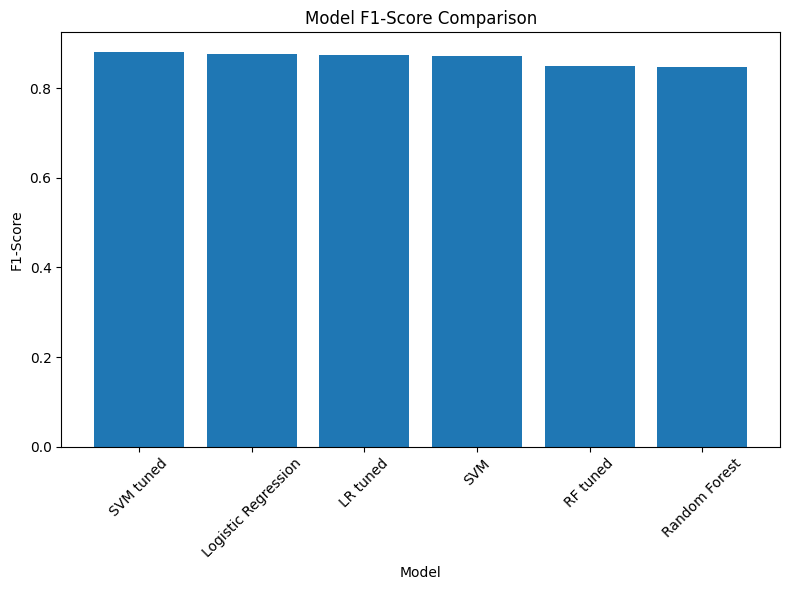

In [12]:
# Sort the combined DataFrame by F1‐score
res_df = df_all.sort_values('f1_score', ascending=False)
display(res_df)

# Bar chart of F1‐Scores using pure matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(res_df.index, res_df['f1_score'])
plt.xlabel('Model')
plt.ylabel('F1‐Score')
plt.title('Model F1‐Score Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 12. Save Model Performance
Export the model performance comparison to a CSV file.

In [ ]:
res_df.to_csv('model_performance_comparison.csv')